# Data analysis Project on Energy Consumption Dataset

### Libraries and Configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### Data loading

In [2]:
path = kagglehub.dataset_download("mrsimple07/energy-consumption-prediction")
print("Path to dataset files:", path)

Path to dataset files: /Users/nameisalfio/.cache/kagglehub/datasets/mrsimple07/energy-consumption-prediction/versions/1


In [3]:
df = pd.read_csv(path + "/Energy_consumption.csv")

print(df.info())
print(df.describe())

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   str    
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   str    
 6   LightingUsage      1000 non-null   str    
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   str    
 9   Holiday            1000 non-null   str    
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), str(5)
memory usage: 86.1 KB
None
       Temperature     Humidity  SquareFootage    Occupancy  RenewableEnergy  \
count  1000.000000  1000.000000    1000.000000  1000.000000      1000.000000   
mean     24.982026    45.395412    1500.052488     4.5810

### Data Preprocessing & Time Engineering

We need to transform the timestamp into a machine-readable format and handle categorical variables.

In [4]:
print(f'Missing values for each column: {df.isna().sum()}')

Missing values for each column: Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64


In [5]:
# 1. Convert Timestamp to datetime objects
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# 2. Extract temporal features
# These are essential for identifying daily and weekly patterns
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek_Num'] = df['Timestamp'].dt.dayofweek # 0=Monday, 6=Sunday

# 3. Check for missing values explicitly
missing_data = df.isnull().sum()
if missing_data.sum() == 0:
    print("Data Integrity Check: No missing values found.")
else:
    print(f"Missing values found:\n{missing_data[missing_data > 0]}")

# 4. Brief look at the updated dataframe
print("\nFirst 5 rows with new temporal features:")
print(df[['Timestamp', 'Hour', 'DayOfWeek', 'EnergyConsumption']].head())

Data Integrity Check: No missing values found.

First 5 rows with new temporal features:
            Timestamp  Hour  DayOfWeek  EnergyConsumption
0 2022-01-01 00:00:00     0     Monday          75.364373
1 2022-01-01 01:00:00     1   Saturday          83.401855
2 2022-01-01 02:00:00     2     Sunday          78.270888
3 2022-01-01 03:00:00     3  Wednesday          56.519850
4 2022-01-01 04:00:00     4     Friday          70.811732


### Univariate Analysis (Target Variable)

Before looking for relationships, we need to understand how energy consumption "moves" on its own. We look for outliers that could compromise future models.

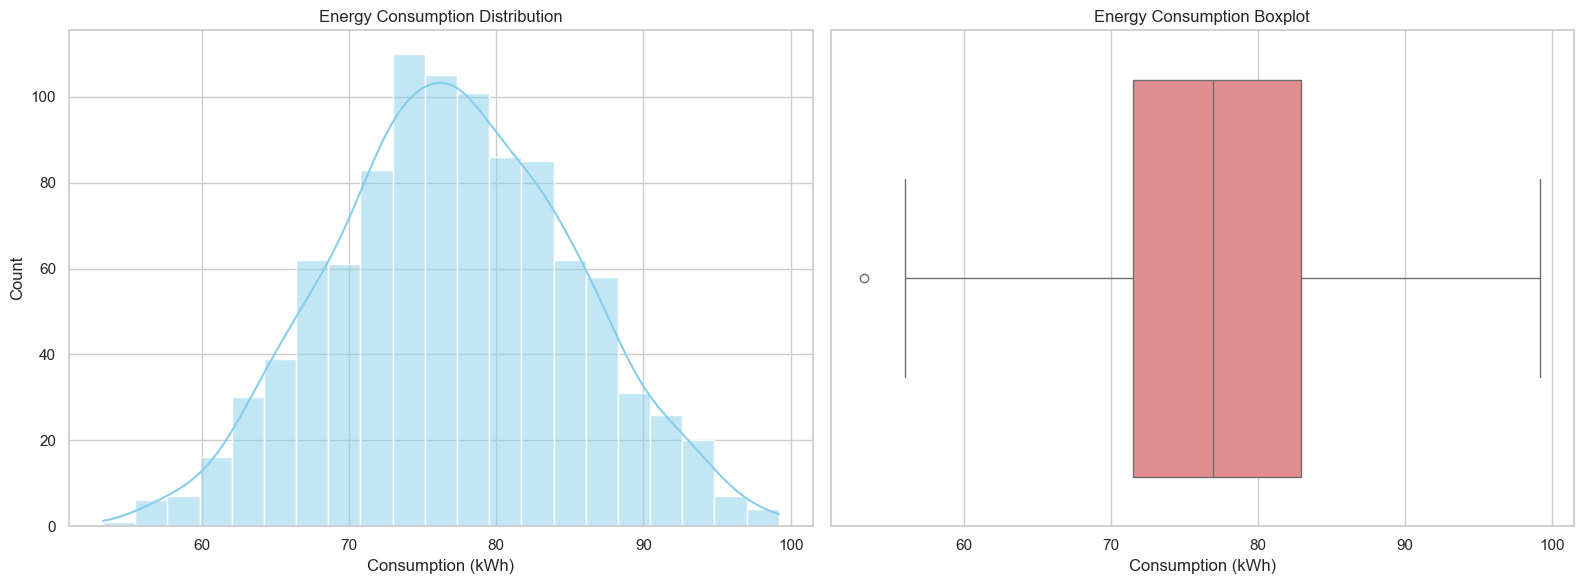

In [6]:
# Setup the visualization grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram & KDE: Check for normality
sns.histplot(df['EnergyConsumption'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Energy Consumption Distribution')
axes[0].set_xlabel('Consumption (kWh)')

# Boxplot: Check for statistical outliers
sns.boxplot(x=df['EnergyConsumption'], ax=axes[1], color='lightcoral')
axes[1].set_title('Energy Consumption Boxplot')
axes[1].set_xlabel('Consumption (kWh)')

plt.tight_layout()
plt.show()

In [7]:
print(f"Skewness: {df['EnergyConsumption'].skew():.2f}")  # should be near 0, indicating symmetry
print(f"Kurtosis (Fisher): {df['EnergyConsumption'].kurt():.2f}")  # should be near 0, indicating a normal distribution

Skewness: 0.03
Kurtosis (Fisher): -0.30


In [8]:
# Quantitative outlier detection using IQR
Q1 = df['EnergyConsumption'].quantile(0.25)
Q2 = df['EnergyConsumption'].quantile(0.5)   # Median
Q3 = df['EnergyConsumption'].quantile(0.75)
Q4 = df['EnergyConsumption'].quantile(1.0)   # Max
mean = df['EnergyConsumption'].mean()
dev_std = df['EnergyConsumption'].std()

IQR = Q3 - Q1  # Interquartile Range
outlier_threshold = 1.5 * IQR

outliers = df[(df['EnergyConsumption'] < Q1 - outlier_threshold) |
              (df['EnergyConsumption'] > Q3 + outlier_threshold)]

print("Statistical Summary for Target Variable:")
print("-" * 50)
print(f"First quantile (Q1): {Q1:.2f}")
print(f"Median (Q2): {Q2:.2f}")
print(f"Third quantile (Q3): {Q3:.2f}")
print(f"Maximum (Q4): {Q4:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {dev_std:.2f}\t Variance: {dev_std**2:.2f}")
print(f"\nPotential outliers detected: {len(outliers)}:\n\n{outliers}")

Statistical Summary for Target Variable:
--------------------------------------------------
First quantile (Q1): 71.54
Median (Q2): 76.94
Third quantile (Q3): 82.92
Maximum (Q4): 99.20
Mean: 77.06
Standard deviation: 8.14	 Variance: 66.33

Potential outliers detected: 1:

             Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
69 2022-01-03 21:00:00    20.735716  48.506636    1836.542651          4   

   HVACUsage LightingUsage  RenewableEnergy DayOfWeek Holiday  \
69       Off            On         9.295439    Friday      No   

    EnergyConsumption  Hour  Day  Month  DayOfWeek_Num  
69          53.263278    21    3      1              0  


### Multivariate Analysis (The "Drivers")

Now let's identify the real drivers of consumption. We will create a correlation matrix to see which numerical variables (Temperature, Humidity, Employment) are most closely related to energy.

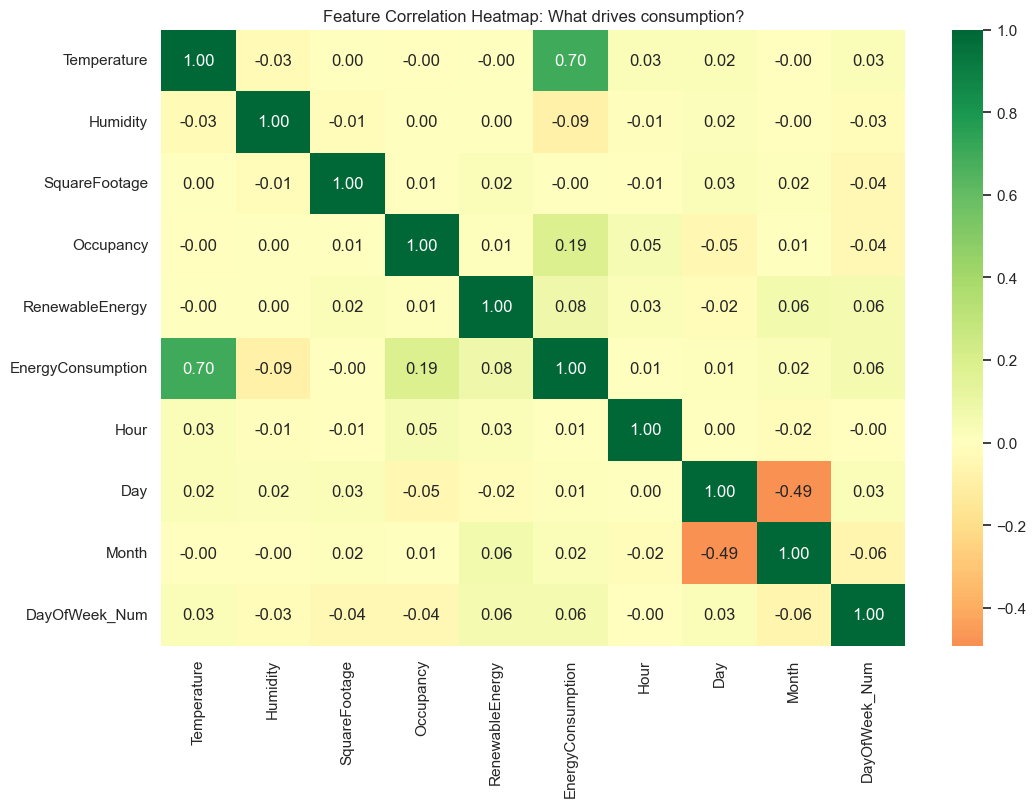

In [9]:
# Select only numerical columns for correlation
numerical_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap: What drives consumption?')
plt.show()

In [10]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) #exclude the upper triangular matrix because of the symmetry 
corr_lower = corr_matrix.mask(mask)

corr_pairs = corr_lower.stack() #convert in tuples
strong_corr = corr_pairs[abs(corr_pairs) >= 0.5].sort_values(key=np.abs, ascending=False)
print("Strong correlations:")
print("-" * 50)
print(strong_corr)

Strong correlations:
--------------------------------------------------
EnergyConsumption  Temperature    0.69641
dtype: float64


### Bivariate Analysis (Deep Dive into Drivers)

We will now visualize the relationship between Temperature and Consumption, and then analyze how categorical variables like HVACUsage and Occupancy shift the consumption baseline.

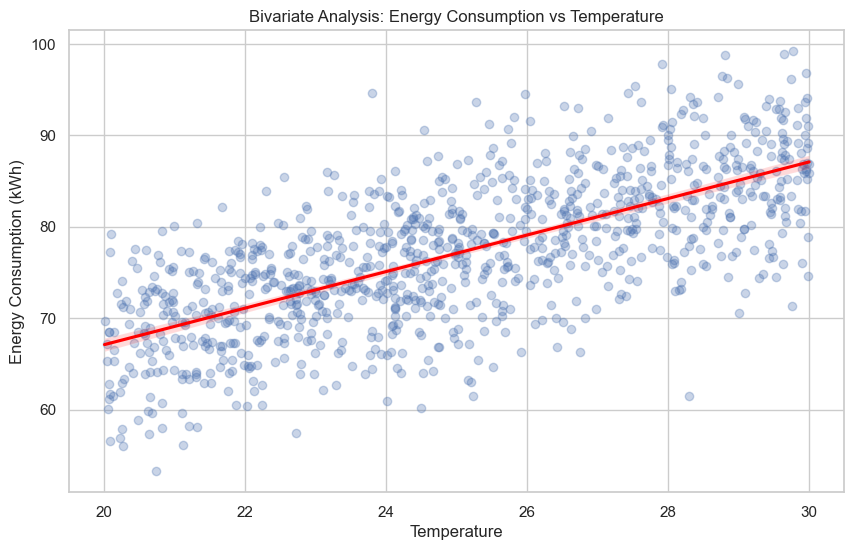

In [11]:
# Visualize the linear relationship between Temperature and Energy Consumption
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Temperature', y='EnergyConsumption', 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Bivariate Analysis: Energy Consumption vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

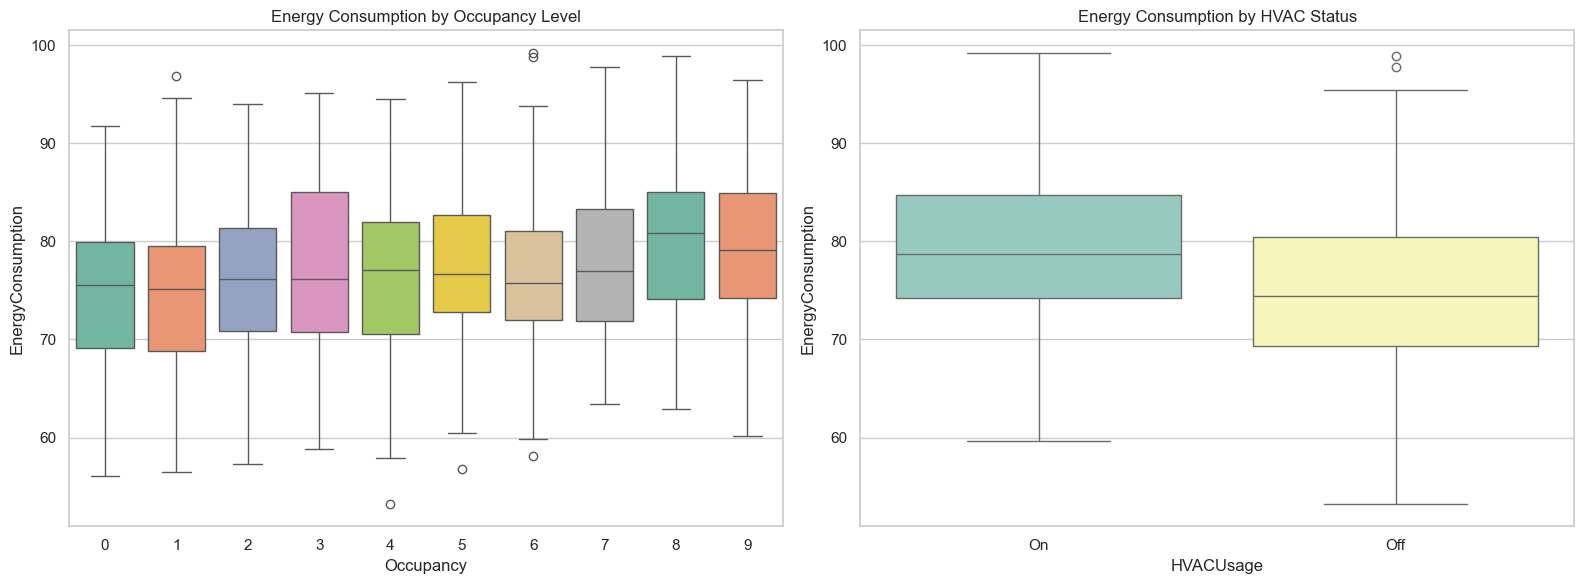

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for Occupancy
sns.boxplot(
    data=df,
    x='Occupancy',
    y='EnergyConsumption',
    hue='Occupancy',     
    palette='Set2',
    ax=axes[0],
    dodge=False,         
    legend=False         
)
axes[0].set_title('Energy Consumption by Occupancy Level')

# Boxplot for HVACUsage
sns.boxplot(
    data=df,
    x='HVACUsage',
    y='EnergyConsumption',
    hue='HVACUsage',     
    palette='Set3',
    ax=axes[1],
    dodge=False,
    legend=False
)
axes[1].set_title('Energy Consumption by HVAC Status')

plt.tight_layout()
plt.show()

- **Occupancy Paradox** : Nota come il consumo mediano per Occupancy = 0 sia molto vicino a quello per Occupancy = 9. Questo è un segnale d'allarme critico: l'edificio consuma quasi la stessa energia sia quando è vuoto che quando è pieno.

- **HVAC Shift** : Il grafico a destra conferma che lo stato "On" del sistema HVAC(Heating, Ventilation, and Air Conditioning) alza l'intero intervallo di consumo, ma esiste un consumo significativo anche quando il sistema è "Off".

### Hourly Load Profile Analysis

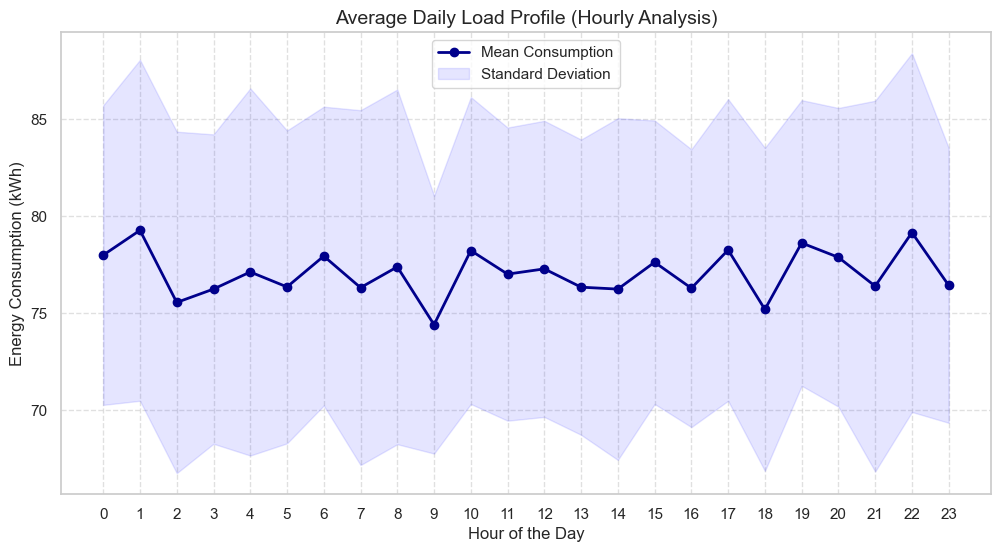

In [13]:
# Create an average hourly profile to identify peak/off-peak patterns
hourly_summary = df.groupby('Hour')['EnergyConsumption'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_summary['Hour'], hourly_summary['mean'], color='darkblue', marker='o', linewidth=2, label='Mean Consumption')
plt.fill_between(hourly_summary['Hour'], 
                 hourly_summary['mean'] - hourly_summary['std'], 
                 hourly_summary['mean'] + hourly_summary['std'], 
                 color='blue', alpha=0.1, label='Standard Deviation')

plt.title('Average Daily Load Profile (Hourly Analysis)', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

- **Time-series Insight** : Look for peaks during working hours. A flat line indicates inefficient constant usage.

### Baseload Calculation

In [14]:
# Calculate the empirical Baseload (10th percentile to avoid outliers)
baseload = df['EnergyConsumption'].quantile(0.1)
peak_load = df['EnergyConsumption'].max()
dynamic_ratio = (peak_load - baseload) / peak_load

print(f"--- Energy Efficiency Metrics ---")
print(f"Empirical Baseload: {baseload:.2f} kWh")
print(f"Peak Demand: {peak_load:.2f} kWh")
print(f"Dynamic Ratio: {dynamic_ratio:.2%}")

--- Energy Efficiency Metrics ---
Empirical Baseload: 66.46 kWh
Peak Demand: 99.20 kWh
Dynamic Ratio: 33.00%


- **Logic** : High baseload (>60% of peak) usually suggests poorly configured systems or 24/7 waste.

### Renewable Energy Impact & Net Consumption

We need to understand whether renewable energy production occurs when it is most needed or whether it is wasted.

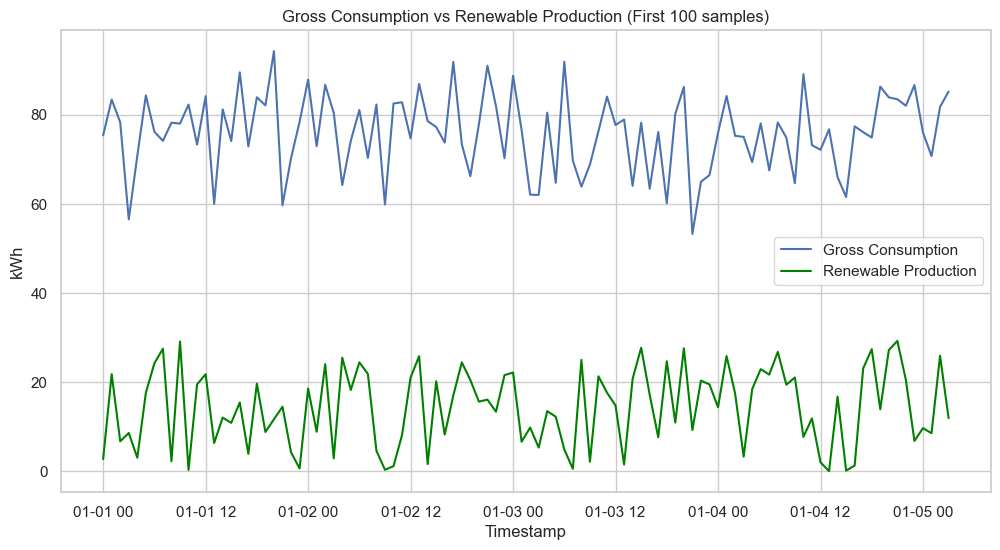

Average Renewable Contribution: 19.64%


In [15]:
# 1. Calculate Net Consumption (Grid reliance)
df['Net_Consumption'] = df['EnergyConsumption'] - df['RenewableEnergy']

# 2. Visualize the offset
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.head(100), x='Timestamp', y='EnergyConsumption', label='Gross Consumption')
sns.lineplot(data=df.head(100), x='Timestamp', y='RenewableEnergy', label='Renewable Production', color='green')
plt.title('Gross Consumption vs Renewable Production (First 100 samples)')
plt.ylabel('kWh')
plt.show()

print(f"Average Renewable Contribution: {(df['RenewableEnergy'].mean() / df['EnergyConsumption'].mean()):.2%}")

### Energy Use Intensity (EUI)

In power engineering, absolute consumption doesn't say it all. A 100m2 building that consumes 80kWh is inefficient compared to a 1000m2 building that consumes the same.

In [16]:
df['EUI'] = df['EnergyConsumption'] / df['SquareFootage']
print(f"Mean EUI: {df['EUI'].mean():.4f} kWh/sqft")

Mean EUI: 0.0534 kWh/sqft


### Holiday and Weekend vs Weekday Analysis

Buildings have different "behaviors" on holidays. If consumption during a Holiday is identical to a working Tuesday, there is a serious error in the system planning (e.g. lights and heating turned on unnecessarily).

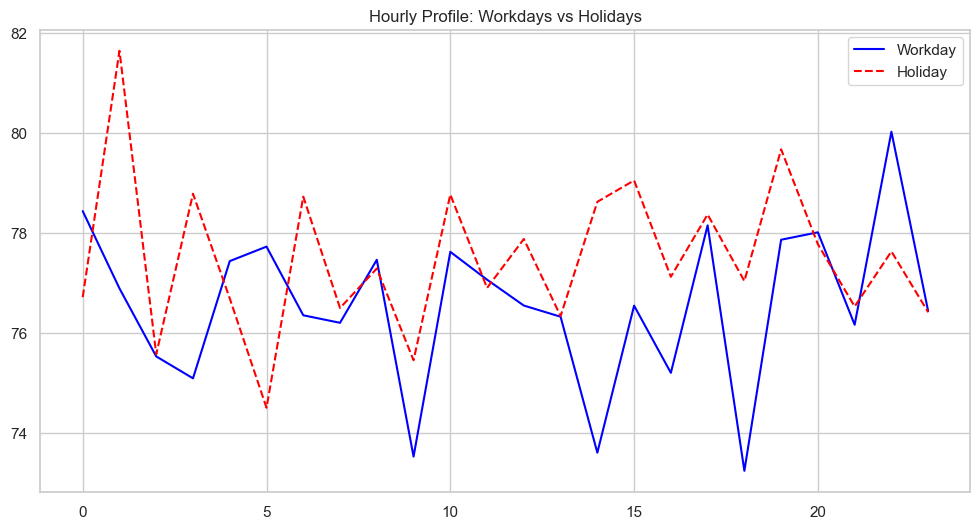

In [17]:
holiday_profile = df[df['Holiday'] == 'Yes'].groupby('Hour')['EnergyConsumption'].mean()
workday_profile = df[df['Holiday'] == 'No'].groupby('Hour')['EnergyConsumption'].mean()

plt.figure(figsize=(12, 6))
plt.plot(workday_profile, label='Workday', color='blue')
plt.plot(holiday_profile, label='Holiday', color='red', linestyle='--')
plt.legend()
plt.title('Hourly Profile: Workdays vs Holidays')
plt.show()

In a properly managed building, we would expect the blue line (Workday) to be consistently above the red line (Holiday), especially during working hours. Instead, let's observe the opposite:

- Higher consumption on holidays: The red line shows consumption peaks (especially around 1, 10 and 19 am) that significantly exceed working day levels.

- Management Inconsistency: This suggests that systems (HVAC, lights) are not turned off or reduced during holidays. On the contrary, they appear to operate under higher loads, which is a clear sign of massive energy waste or incorrect timer scheduling.

## Statistical Significance and Feature Selection (Backward Elimination)

In [18]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# 1. Encoding categorical variables for statistical analysis
le = LabelEncoder()
df_stat = df.copy()

categorical_to_encode = ['HVACUsage', 'LightingUsage', 'Holiday']
for col in categorical_to_encode:
    df_stat[col] = le.fit_transform(df_stat[col].astype(str))

# 2. Define initial features (excluding non-numerical and target variables)
features = [
    'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 
    'HVACUsage', 'LightingUsage', 'RenewableEnergy', 
    'Hour', 'DayOfWeek_Num', 'Holiday'
]

X = df_stat[features]
y = df_stat['EnergyConsumption']

# 3. Add a constant (intercept) as required by statsmodels for OLS
X = sm.add_constant(X)

# 4. Backward Elimination Process
def perform_backward_elimination(X, y, alpha=0.05):
    current_features = X.columns.tolist()
    while len(current_features) > 0:
        # Fit the OLS model
        model = sm.OLS(y, X[current_features]).fit()
        
        # Get the feature with the highest p-value
        max_p_value = model.pvalues.max()
        if max_p_value > alpha:
            excluded_feature = model.pvalues.idxmax()
            print(f"Removing '{excluded_feature}' (p-value: {max_p_value:.4f})")
            current_features.remove(excluded_feature)
        else:
            break
    return model

# 5. Execute and Display Results
final_stat_model = perform_backward_elimination(X, y)

print("\n" + "="*20 + " FINAL STATISTICAL SUMMARY " + "="*20)
print(final_stat_model.summary())

Removing 'SquareFootage' (p-value: 0.5861)
Removing 'DayOfWeek_Num' (p-value: 0.3839)
Removing 'Hour' (p-value: 0.3239)
Removing 'Holiday' (p-value: 0.3058)

==================== FINAL STATISTICAL SUMMARY ====================
                            OLS Regression Results                            
Dep. Variable:      EnergyConsumption   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     269.4
Date:                Mon, 26 Jan 2026   Prob (F-statistic):          2.22e-204
Time:                        22:10:21   Log-Likelihood:                -3032.6
No. Observations:                1000   AIC:                             6079.
Df Residuals:                     993   BIC:                             6114.
Df Model:                           6                                         
Covariance Type:            nonrobust                          

### Visualization of Significant Drivers

Once the non-significant features are removed, we can plot the coefficients to see which variables have the greatest weight (positive or negative) on energy consumption.

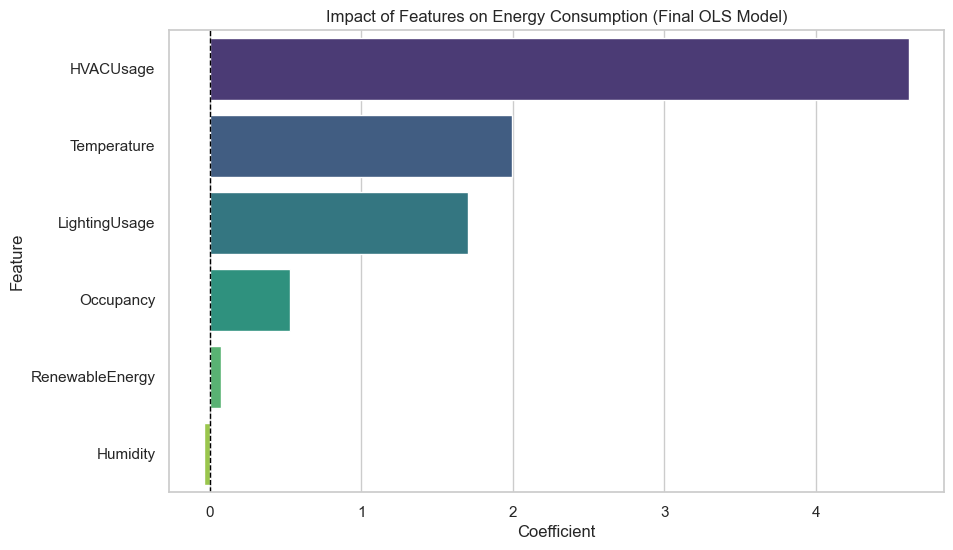

In [19]:
# Extract coefficients and p-values from the final model
coef_df = pd.DataFrame({
    'Feature': final_stat_model.params.index,
    'Coefficient': final_stat_model.params.values,
    'P-Value': final_stat_model.pvalues.values
}).sort_values(by='Coefficient', ascending=False)

coef_df = coef_df[coef_df['Feature'] != 'const']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df, 
    x='Coefficient', 
    y='Feature', 
    hue='Feature', 
    palette='viridis', 
    legend=False
)

plt.title('Impact of Features on Energy Consumption (Final OLS Model)')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.show()

### Verification of Residuals

A key assumption for the validity of the t-test and F-test is that residuals are normally distributed and independent.

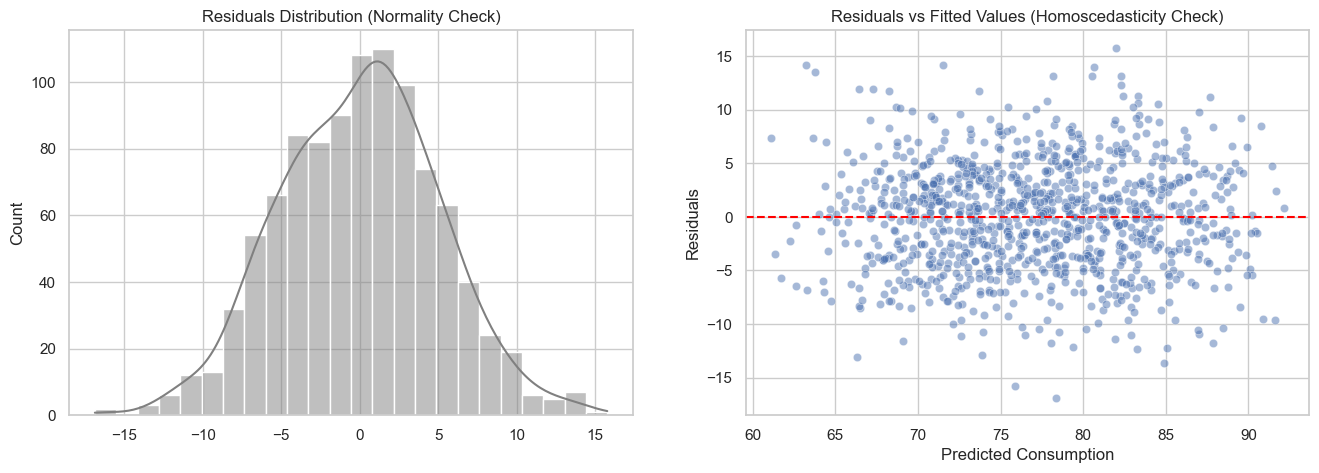

In [20]:
# Plotting Residuals Distribution
residuals = final_stat_model.resid

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(residuals, kde=True, ax=axes[0], color='gray')
axes[0].set_title('Residuals Distribution (Normality Check)')

sns.scatterplot(x=final_stat_model.fittedvalues, y=residuals, ax=axes[1], alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Residuals vs Fitted Values (Homoscedasticity Check)')
axes[1].set_xlabel('Predicted Consumption')
axes[1].set_ylabel('Residuals')

plt.show()

In [21]:
selected_features = final_stat_model.pvalues[final_stat_model.pvalues < 0.05].index.tolist()
if 'const' in selected_features: selected_features.remove('const')

print("Selected features for modeling based on statistical significance:")
print(selected_features)

Selected features for modeling based on statistical significance:
['Temperature', 'Humidity', 'Occupancy', 'HVACUsage', 'LightingUsage', 'RenewableEnergy']


## Predictive Modelling
___

### Data preprocessing 

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Feature filtering based on statistical significance
# This list is derived from the p-values of the preliminary statistical model
selected_features = final_stat_model.pvalues[final_stat_model.pvalues < 0.05].index.tolist()
if 'const' in selected_features: 
    selected_features.remove('const')

# 2. Data Preparation and Categorical Encoding
le = LabelEncoder()
df_ml = df.copy()

# Identify which categorical columns are present in the selected features
categorical_targets = ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']
active_categoricals = [col for col in categorical_targets if col in selected_features]

for col in active_categoricals:
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))

# 3. Dynamic Feature Selection
# X is constructed using only the statistically significant predictors
X = df_ml[selected_features].values
y = df_ml['EnergyConsumption'].values.reshape(-1, 1)

# 4. Dataset Partitioning (Train/Test Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Feature and Target Scaling
# Standardizing features to mean=0 and variance=1 for optimal gradient descent
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# 6. Tensor Conversion for PyTorch Compatibility
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

print(f"Training set size: {X_train_t.shape[0]} samples with {X_train_t.shape[1]} features.")
print(f"Testing set size: {X_test_t.shape[0]} samples.")

Training set size: 800 samples with 6 features.
Testing set size: 200 samples.


### Definition of Regression model

In [23]:
class EnergyRegressor(nn.Module):
    def __init__(self, input_dim):
        super(EnergyRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.net(x)

### Training Loop

We will use the MSE loss function defined as:

$$
MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y_i})^2
$$

In [24]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=len(test_ds)) 
print(f"Batches in training loader: {len(train_loader)}")

Batches in training loader: 25


In [25]:
model = EnergyRegressor(X_train_t.shape[1])
print(model)
print('-' * 50)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    # --- Training phase ---
    model.train()
    running_train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass on the mini-batch
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Average training loss for the batch
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # --- Validation phase ---
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for val_X, val_y in val_loader:
            prediction = model(val_X)
            v_loss = criterion(prediction, val_y)
            running_val_loss += v_loss.item()
            
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Avg Train Loss: {epoch_train_loss:.4f} | Avg Val Loss: {epoch_val_loss:.4f}")

EnergyRegressor(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
--------------------------------------------------
Epoch [50/50] | Avg Train Loss: 0.3806 | Avg Val Loss: 0.4111


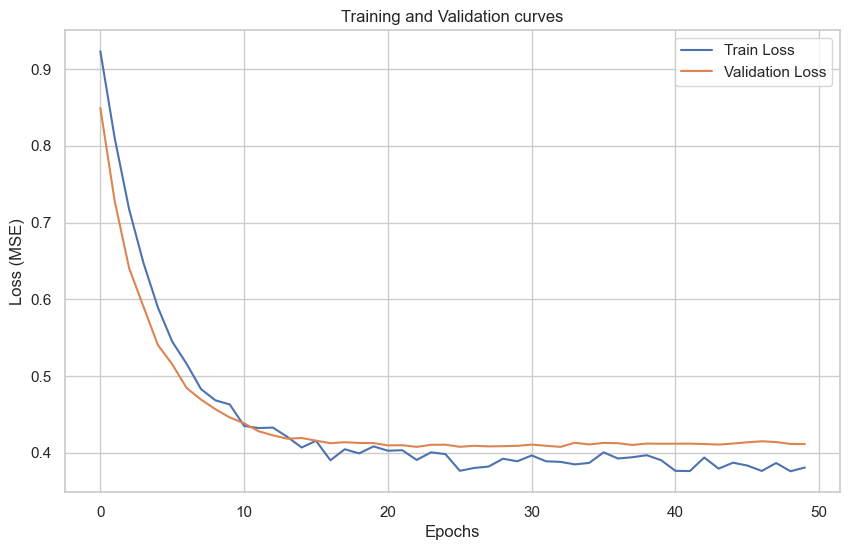

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation curves')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

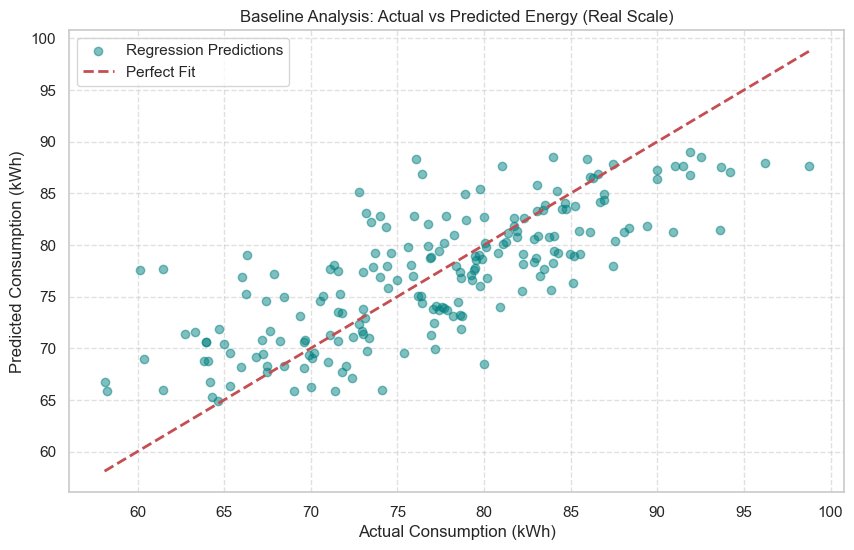

--- Final Metrics of the Regression Model ---
Mean Absolute Error (MAE): 4.12 kWh
Mean Squared Error (MSE):  27.32 kWh^2
R2 Score:                  0.5829


In [27]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

model.eval()

with torch.no_grad():
    predictions_scaled = model(X_test_t)
    predictions_numpy = predictions_scaled.cpu().numpy()
    actuals_numpy = y_test_t.cpu().numpy()
    
    # Inverse transform per tornare alla scala reale kWh
    predictions_kwh = scaler_y.inverse_transform(predictions_numpy)
    actuals_kwh = scaler_y.inverse_transform(actuals_numpy)

# Visualizing Predictions vs Actual (in kWh)
plt.figure(figsize=(10, 6))
plt.scatter(actuals_kwh, predictions_kwh, alpha=0.5, color='teal', label='Regression Predictions')
plt.plot([actuals_kwh.min(), actuals_kwh.max()], [actuals_kwh.min(), actuals_kwh.max()], 
         'r--', lw=2, label='Perfect Fit')

plt.xlabel('Actual Consumption (kWh)')
plt.ylabel('Predicted Consumption (kWh)')
plt.title('Baseline Analysis: Actual vs Predicted Energy (Real Scale)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

mae_kwh = mean_absolute_error(actuals_kwh, predictions_kwh)
mse_kwh = mean_squared_error(actuals_kwh, predictions_kwh)
r2 = r2_score(actuals_kwh, predictions_kwh)

print(f"--- Final Metrics of the Regression Model ---")
print(f"Mean Absolute Error (MAE): {mae_kwh:.2f} kWh")
print(f"Mean Squared Error (MSE):  {mse_kwh:.2f} kWh^2")
print(f"R2 Score:                  {r2:.4f}")

In [28]:
from sklearn.metrics import r2_score, explained_variance_score

# 1. Calculation of the Coefficient of Determination (R2 Score)
# R2 represents the proportion of variance for the dependent variable 
# that is explained by the independent variables in the model.
r2 = r2_score(actuals_kwh, predictions_kwh)

# 2. Calculation of the Explained Variance Score
# This score measures the proportion to which a mathematical model accounts 
# for the variation (dispersion) of a given data set.
evs = explained_variance_score(actuals_kwh, predictions_kwh)

print("-" * 50)
print(f"Model Performance Metrics (Real Scale):")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Explained Variance Score: {evs:.4f}")
print("-" * 50)

# Interpretation
if r2 > 0.7:
    print("The model explains a significant portion of the energy consumption variance.")
else:
    print("The model shows moderate predictive power; consider further feature engineering.")

--------------------------------------------------
Model Performance Metrics (Real Scale):
R-squared (R2) Score: 0.5829
Explained Variance Score: 0.5829
--------------------------------------------------
The model shows moderate predictive power; consider further feature engineering.


----

## From Determinism to Probability: Why Probabilistic Forecasting?

The exploratory analysis and initial regression tests highlighted that energy consumption is not a purely stochastic or isolated phenomenon, but a dynamic process with strong temporal dependencies. Framing the problem as a **Probabilistic Forecasting** task instead of classic **Regression** offers three crucial competitive advantages for a *Digital Twin*:

### 1. Modeling Temporal Dependency (Sequentiality)
Unlike standard regression, which treats each record as independent ($P(y|x)$), forecasting recognizes that consumption at time $t$ is intrinsically linked to previous instances ($P(y_t | x_t, y_{t-1}, ..., y_{t-n})$). The use of **LSTM** architectures allows mapping the building's thermal inertia and operational cycles, which a static regressor perceives as noise, artificially lowering the explained variance ($R^2$).

### 2. Managing Uncertainty (Confidence Intervals)
In a critical monitoring system, knowing the point value (e.g., 75 kWh) is less useful than knowing the confidence interval. **Probabilistic Forecasting** provides a probability distribution:
* **Regression**: "I predict 75 kWh."
* **Probabilistic**: "I predict 75 kWh with a standard deviation of 2 kWh."
This allows defining dynamic alert thresholds: a consumption of 80 kWh might be normal on a hot afternoon (high uncertainty) but critical during a winter night (low uncertainty).

### 3. Anomaly Detection Based on Likelihood
By transforming the task into a probabilistic one, fault detection evolves. We no longer look for a fixed percentage deviation but calculate the **Log-Likelihood** of the observed data. If the actual consumption falls in the "tails" of the distribution predicted by the model, the system flags an anomaly with a degree of statistical certainty, drastically reducing the false positives typical of threshold-based systems.

In [29]:
from sklearn.preprocessing import RobustScaler
from scipy import stats

# Loading and cleaning
df_nexus = df.copy()
df_nexus['Timestamp'] = pd.to_datetime(df_nexus['Timestamp'])

# Removing Outliers (Z-score > 3)
df_nexus = df_nexus[np.abs(stats.zscore(df_nexus['EnergyConsumption'])) < 3]

# Categorical Mapping
usage_map = {'On': 1, 'Off': 0}
df_nexus['HVACUsage'] = df_nexus['HVACUsage'].map(usage_map)
df_nexus['LightingUsage'] = df_nexus['LightingUsage'].map(usage_map)

# Feature Engineering: Cyclicality and Short-term Lag
df_nexus['hour_sin'] = np.sin(2 * np.pi * df_nexus['Timestamp'].dt.hour / 24)
df_nexus['hour_cos'] = np.cos(2 * np.pi * df_nexus['Timestamp'].dt.hour / 24)
df_nexus['Lag_1h'] = df_nexus['EnergyConsumption'].shift(1)

# Light smoothing to remove sensor noise
df_nexus['EnergyConsumption'] = df_nexus['EnergyConsumption'].rolling(window=2, center=True).mean()
df_nexus = df_nexus.dropna()

# Final Feature Selection
df_nexus['Temp_Trend'] = df_nexus['Temperature'].diff().fillna(0)
features = ['Temperature', 'Temp_Trend', 'Occupancy', 'HVACUsage', 'Lag_1h', 'hour_sin', 'hour_cos']
target = 'EnergyConsumption'

In [30]:
train_size = int(len(df_nexus) * 0.8)
train_df = df_nexus.iloc[:train_size]
test_df = df_nexus.iloc[train_size:]

scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_train_raw = scaler_X.fit_transform(train_df[features])
y_train_raw = scaler_y.fit_transform(train_df[[target]])
X_test_raw = scaler_X.transform(test_df[features])
y_test_raw = scaler_y.transform(test_df[[target]])

WINDOW_SIZE = 12

def prepare_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i : i + window])
        ys.append(y[i + window])
    return torch.tensor(np.array(Xs), dtype=torch.float32), \
           torch.tensor(np.array(ys), dtype=torch.float32)

X_train, y_train = prepare_sequences(X_train_raw, y_train_raw, WINDOW_SIZE)
X_test, y_test = prepare_sequences(X_test_raw, y_test_raw, WINDOW_SIZE)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

In [31]:
class NexusLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=8):
        super(NexusLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        # hn[-1] is the last hidden state: [batch, hidden_dim]
        out = self.bn(hn[-1])
        out = self.dropout(out)
        return self.fc(out)

Epoch [50/200] | Train: 0.1856 | Val: 0.1889 | LR: 0.000125
Epoch [100/200] | Train: 0.1868 | Val: 0.1877 | LR: 0.000004
Epoch [150/200] | Train: 0.1846 | Val: 0.1881 | LR: 0.000000
Epoch [200/200] | Train: 0.1786 | Val: 0.1872 | LR: 0.000000


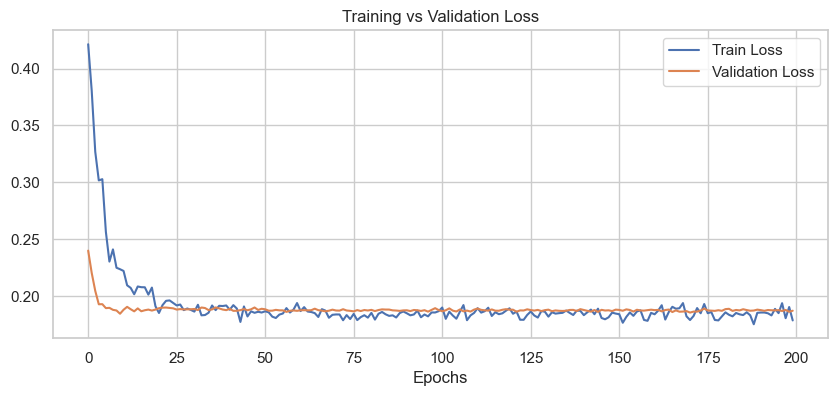

In [32]:
model = NexusLSTM(input_dim=len(features))
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

epochs = 200
history = {'train_loss': [], 'val_loss': []}

for epoch in range(epochs):
    model.train()
    train_running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    
    avg_train_loss = train_running_loss / len(train_loader)
    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test)
        avg_val_loss = criterion(val_preds, y_test).item()
        scheduler.step(avg_val_loss)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")


# Plot convergence
plt.figure(figsize=(10, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

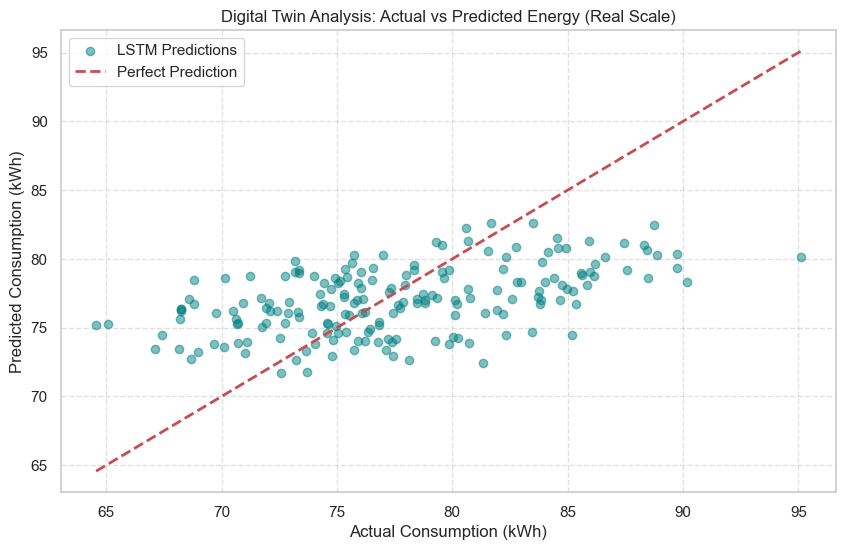

--- Final Metrics of the Recurrent Model ---
Mean Absolute Error (MAE): 4.10 kWh
Mean Squared Error (MSE):  24.96 kWh^2
R2 Score:                  0.2434


In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # Generate predictions using the test set
    predictions_scaled = model(X_test)
    predictions_numpy = predictions_scaled.cpu().numpy()
    actuals_numpy = y_test.cpu().numpy()
    
    # Inverse transform the scaled predictions and actual values to their original scale
    predictions_kwh = scaler_y.inverse_transform(predictions_numpy)
    actuals_kwh = scaler_y.inverse_transform(actuals_numpy)

# Plot the actual vs predicted energy consumption
plt.figure(figsize=(10, 6))
plt.scatter(actuals_kwh, predictions_kwh, alpha=0.5, color='teal', label='LSTM Predictions')
plt.plot([actuals_kwh.min(), actuals_kwh.max()], [actuals_kwh.min(), actuals_kwh.max()], 
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Consumption (kWh)')
plt.ylabel('Predicted Consumption (kWh)')
plt.title('Digital Twin Analysis: Actual vs Predicted Energy (Real Scale)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate Metrics
mae_kwh = mean_absolute_error(actuals_kwh, predictions_kwh)
mse_kwh = mean_squared_error(actuals_kwh, predictions_kwh)
r2 = r2_score(actuals_kwh, predictions_kwh)

print(f"--- Final Metrics of the Recurrent Model ---")
print(f"Mean Absolute Error (MAE): {mae_kwh:.2f} kWh")
print(f"Mean Squared Error (MSE):  {mse_kwh:.2f} kWh^2")
print(f"R2 Score:                  {r2:.4f}")

---

## **Probabilistic Evolution: Transition to Negative Log Likelihood (NLL)**

So far, we have treated energy consumption prediction as a **deterministic** problem: the model receives inputs and returns a single point value (Point Estimation). However, a building’s energy consumption is an inherently **stochastic** phenomenon, influenced by unobserved variables and sensor noise.

The Negative Log Likelihood (NLL) loss function allows us to embrace this uncertainty by predicting a **probability distribution** for each time step instead of a single value. It is defined as follows for a Gaussian distribution:

$$
NLL = \frac{1}{2} \log(2 \pi \sigma^2) + \frac{(y - \mu)^2}{2\sigma^2}
$$

Where:
* $y$ = Actual consumption
* $\mu$ = Predicted mean consumption
* $\sigma^2$ = Predicted variance (uncertainty)

### **Why NLL?**
The **Gaussian Negative Log Likelihood** allows us to model predictions not as a single number, but as a **probability distribution**.

* **Instead of:** $Output = y$
* **Now:** $Output = \mathcal{N}(\mu, \sigma^2)$

The model will learn to provide two pieces of information for each time step:
1. **Mean ($\mu$):** The most probable consumption value (the one we will use for MAE).
2. **Variance ($\sigma^2$):** The model’s degree of uncertainty. A high variance indicates that the data at that moment are chaotic or contradictory; a low variance indicates high confidence in the prediction.

### **Benefits for the Digital Twin**
* **Noise Resilience:** NLL penalizes errors less when the model has predicted high uncertainty ($\sigma$), preventing network weights from being distorted by sudden outliers.
* **Confidence Intervals:** We can generate confidence bands (e.g., $\pm 2\sigma$) that indicate when real consumption is deviating from expected behavior (Anomaly Detection).

---

In [41]:
class NexusProbabilisticLSTM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 12):
        super(NexusProbabilisticLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.4) 
        self.fc_mu = nn.Linear(hidden_dim, 1)
        self.fc_sigma = nn.Linear(hidden_dim, 1)
        self.softplus = nn.Softplus()

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        x = self.bn(hn[-1])
        x = self.dropout(x) 
        mu = self.fc_mu(x)
        sigma = self.softplus(self.fc_sigma(x)) + 1e-6
        return mu, sigma

In [42]:
model = NexusProbabilisticLSTM(input_dim=len(features))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.GaussianNLLLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25)

# --- Training Loop with Validation and Scheduling ---
epochs = 250
history = {'train_loss': [], 'val_loss': []}

for epoch in range(epochs):
    model.train()
    train_running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        mu, sigma = model(batch_X)
        # NLL requires mean, target, and variance (sigma^2)
        loss = criterion(mu, batch_y, sigma**2)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_running_loss += loss.item()

        optimizer.step()
        train_running_loss += loss.item()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_mu, val_sigma = model(X_test)
        val_loss = criterion(val_mu, y_test, val_sigma**2).item()
    
    # Update scheduler based on validation performance
    scheduler.step(val_loss)
    
    avg_train_loss = train_running_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    
    if (epoch + 1) % 20 == 0:
        curr_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{epochs}] | Train: {avg_train_loss:.4f} | Val: {val_loss:.4f} | LR: {curr_lr:.6f}")

Epoch [20/250] | Train: 0.4457 | Val: 0.0718 | LR: 0.000100
Epoch [40/250] | Train: 0.2482 | Val: 0.0358 | LR: 0.000100
Epoch [60/250] | Train: 0.0928 | Val: 0.0232 | LR: 0.000100
Epoch [80/250] | Train: 0.1085 | Val: 0.0170 | LR: 0.000100
Epoch [100/250] | Train: -0.0062 | Val: 0.0229 | LR: 0.000050
Epoch [120/250] | Train: 0.0031 | Val: 0.0267 | LR: 0.000050
Epoch [140/250] | Train: -0.0128 | Val: 0.0221 | LR: 0.000025
Epoch [160/250] | Train: -0.0084 | Val: 0.0216 | LR: 0.000013
Epoch [180/250] | Train: 0.0103 | Val: 0.0281 | LR: 0.000006
Epoch [200/250] | Train: 0.0251 | Val: 0.0209 | LR: 0.000003
Epoch [220/250] | Train: -0.0168 | Val: 0.0255 | LR: 0.000003
Epoch [240/250] | Train: -0.0100 | Val: 0.0228 | LR: 0.000002



--- Final Probabilistic Results with Scheduling ---
MAE (Mean): 4.09 kWh
R2 Score: 0.2495


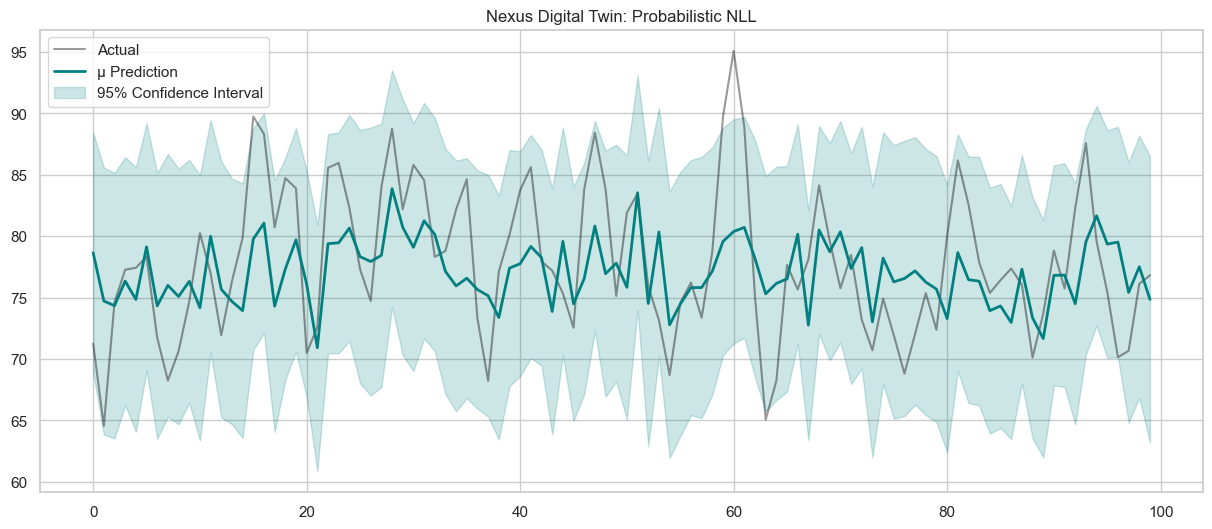

In [43]:
model.eval()
with torch.no_grad():
    mu_scaled, sigma_scaled = model(X_test)
    predictions_kwh = scaler_y.inverse_transform(mu_scaled.cpu().numpy())
    actuals_kwh = scaler_y.inverse_transform(y_test.cpu().numpy())
    # Scale uncertainty back to kWh
    std_kwh = sigma_scaled.cpu().numpy() * scaler_y.scale_

mae_final = mean_absolute_error(actuals_kwh, predictions_kwh)
r2_final = r2_score(actuals_kwh, predictions_kwh)

print(f"\n--- Final Probabilistic Results with Scheduling ---")
print(f"MAE (Mean): {mae_final:.2f} kWh")
print(f"R2 Score: {r2_final:.4f}")

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(actuals_kwh[:100], label='Actual', color='black', alpha=0.4)
plt.plot(predictions_kwh[:100], label='μ Prediction', color='teal', linewidth=2)
plt.fill_between(
    range(100),
    (predictions_kwh[:100] - 1.96 * std_kwh[:100]).flatten(),
    (predictions_kwh[:100] + 1.96 * std_kwh[:100]).flatten(),
    color='teal', alpha=0.2, label='95% Confidence Interval'
)
plt.title('Nexus Digital Twin: Probabilistic NLL')
plt.legend()
plt.show()

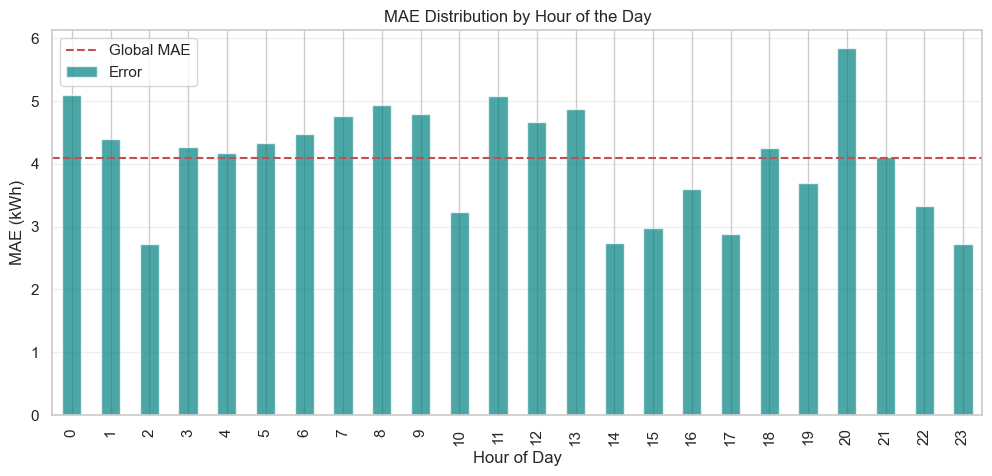

In [46]:
# Analysis of Residuals by Hour
test_results = test_df.iloc[WINDOW_SIZE:].copy()
test_results['Error'] = np.abs(actuals_kwh - predictions_kwh)
test_results['Hour'] = test_results['Timestamp'].dt.hour

# Calculate average MAE per hour
hourly_mae = test_results.groupby('Hour')['Error'].mean()

plt.figure(figsize=(12, 5))
hourly_mae.plot(kind='bar', color='teal', alpha=0.7)
plt.axhline(y=mae_final, color='r', linestyle='--', label='Global MAE')
plt.title('MAE Distribution by Hour of the Day')
plt.ylabel('MAE (kWh)')
plt.xlabel('Hour of Day')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

### **Hourly Performance Analysis**
The bar chart highlighting the **MAE by Hour of Day** reveals a non-uniform distribution of uncertainty:
* **Stability during Low Activity:** The model is most accurate during off-peak hours (e.g., 02:00, 14:00, 23:00), where the error drops below 3 kWh. This indicates that the base thermal load of the building is well understood.
* **Transition Noise (07:00 - 13:00):** A sustained error above the global average during the morning suggests that the "ramp-up" phase of the building is stochastic. Human arrivals and HVAC ignition timing vary slightly each day, creating a ceiling of unpredictability.
* **Peak Anomaly (20:00):** The significant spike at 8 PM suggests an unobserved behavioral variable (e.g., specific evening cleaning shifts or security protocols) that the current feature set cannot account for.

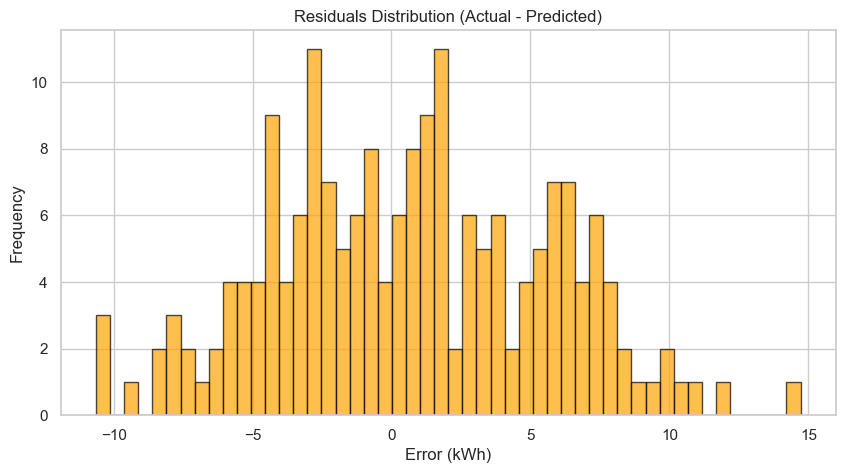

In [47]:
# Residual Distribution Check
plt.figure(figsize=(10, 5))
residuals = actuals_kwh - predictions_kwh
plt.hist(residuals, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.title('Residuals Distribution (Actual - Predicted)')
plt.xlabel('Error (kWh)')
plt.ylabel('Frequency')
plt.show()

### **Residuals Distribution and Multimodality**
The histogram of residuals (**Actual - Predicted**) provides the "statistical signature" of our model:
* **Zero-Centered Bias:** The distribution is centered at zero, proving that the model is **unbiased**. It does not systematically overestimate or underestimate consumption.
* **Multimodal Nature:** Instead of a perfect Gaussian curve, we see multiple peaks (e.g., at -3, +2, and +6 kWh). This confirms that the dataset contains several "operational modes" (e.g., different types of occupancy days) that overlap.
* **Positive Skewness (Underestimation):** The longer tail on the right indicates that the model is conservative; it tends to underpredict extreme energy spikes rather than overpredicting them. This is a typical effect of the **Dropout** and **Huber Loss** regularization used to maintain stability.